# Task 2: Explorative Datenanalyse

## Einleitung

In diesem Teil wollen wir eine visuelle Übersicht der Nutzer-, Rating- und Filmtext-Daten und ihrer Zusammenhänge erstellen. Diese soll zur Datenbereinigung und für die anschliessende Evaluierung des Content-Based Recommender Systems verwendet werden.

Als erstes importieren wir die benötigten Libraries wie folgt.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from p import stemming_tokenizer

Hier lesen wir die beiden Dataframes ein.
- df_movies_ratings: Nutzerbewertungen
- df_movies_clean: Bereinigtes Dataframe mit Filme

In [3]:
# import ratings dataframe
df_movies_ratings = pd.read_csv('ml-25m/df_movies_ratings.csv')

# import movie dataframe
df_movies_clean = pd.read_csv('ml-25m/movies_clean.csv')

Als erstes wollen wir nun zählen welcher Film wie oft bewertet wurde. Dazu haben wir eine neue Variabel erstellt, in der wir alle Ratings pro Film zusammengefasst haben. 

In [4]:
# group by title and count ratings
df_movies_sum_ratings = df_movies_ratings.groupby("title")["rating"].count().sort_values(ascending = False).reset_index()

Anhand dieser Daten können wir nun herausfinden, welche Filme am häufigsten bewertet worden sind.

Dabei haben wir nur die Filme berücksichtigt, welche mindestens 11 Bewertungen haben.

In [5]:
# show movies with more than 10 ratings (only 6.6k movies)
df_movies_10_ratings = df_movies_sum_ratings[df_movies_sum_ratings["rating"] > 10]
df_movies_10_ratings

,title,rating
0,Inception,38895
1,Interstellar,22634
2,Django Unchained,20686
3,The Dark Knight Rises,19911
4,Shutter Island,18886
...,...,...
6473,Radiostars,11
6474,Platinum Data,11
6475,Swallows and Amazons,11
6476,Barbie: Dolphin Magic,11


Wir sehen jetzt, dass es 6478 Filme gibt, welche 11 oder mehr Bewertungen haben. Mit diesen Filmen können wir nun weiterarbeiten. 

Wir stellen uns folgende Frage:

#### 1. Welches sind die am häufigsten geschauten Genres/Filme?

Um diese Frage beantworten zu können mussten wir als erstes ein neues Dataframe namens "df_genres" erstellen. In dem Dataframe haben wir je eine Spalte pro Genre hinzugefügt. Die Spalte beinhaltet eine 1, wenn der Film zu dem entsprechenden Genre gehört und eine 0, falls nicht. Um die Spalten mit den Genres anzuhängen benutzen wir den Befehl "get_dummies". Um die neuen Spalten mit dem bereits vorhanden Dataframe zusammenzufügen, benutzen wir "pd.concat". 

Das neue Dataframe sieht nun wie folgt aus:

In [6]:
# separate genres and add them as columns, 0 = not in genre, 1 = in genre
dum = df_movies_ratings['genres'].str.get_dummies(sep = '|')
df_genres = pd.concat([df_movies_ratings, dum], axis=1)
df_genres.head()

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",118,en,English,Alcon Entertainment|Silver Pictures,...,0,0,0,0,0,1,0,1,0,0


Es gibt Filme, die mehrere Genres haben (z.B. wie oben zu sehen, "The Book of Eli") --> Diese 4 Genres werden alle zu dem jeweiligen Genre dazugezählt. Dadurch, haben wir am Schluss viel mehr Genres, als es eigentlich Filme gibt, da die meisten Filme mehr als nur ein Genre haben.

Wir können nun herausfinden, welche Genre sehr oft und welche Genre nicht so oft geschaut wurden. Dazu erstellen wir ein Barplot mit den Genres gemessen an der Anzahl an Bewertungen, die sie haben.

<ipython-input-7-668857f906af>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([float(x/1000000) for x in ax.get_yticks()])


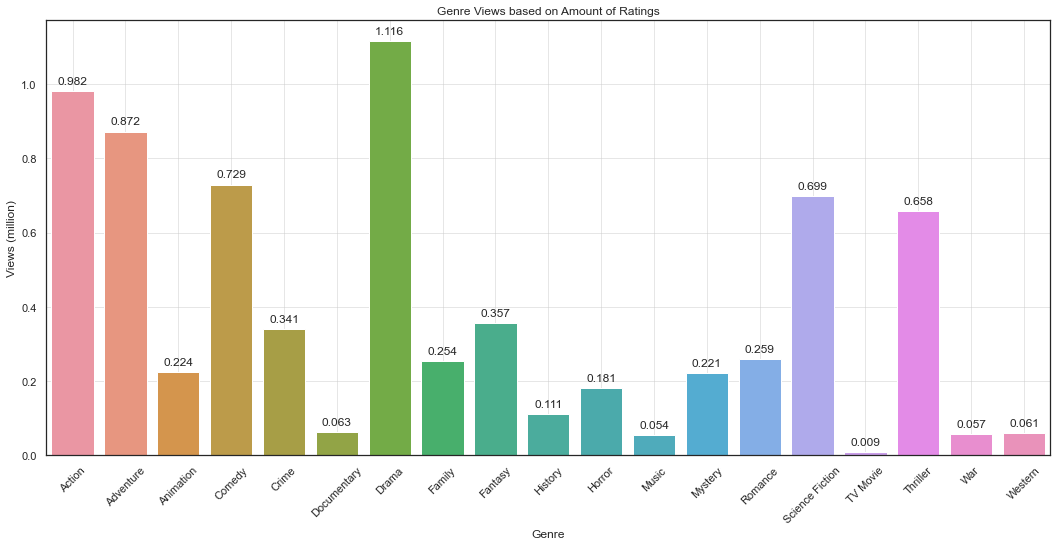

In [7]:
sns.set(rc={'figure.figsize':(18,8)})

# change theme to white
sns.set_theme(style = "white")

# create barplot with the amount of genre occurences
ax = sns.barplot(data = df_genres.iloc[:,-19:].sum().reset_index(), x = "index", y = 0)

# remove "1e6" from plot
ax.ticklabel_format(style='plain', axis='y')

# devide y axis by 1 million (easier to read on the graph)
ax.set_yticklabels([float(x/1000000) for x in ax.get_yticks()])

# add text in millions, rounded by 3 decimals to bars
for p in ax.patches:
    ax.annotate(format(p.get_height()/1000000, '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set(xlabel='Genre', ylabel='Views (million)', title="Genre Views based on Amount of Ratings")
plt.xticks(rotation = 45)
plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

Man erkennt, dass das Genre Drama mit Abstand am häufigsten vertreten ist. Es folgen Action, Adventure und Comedy. Die restlichen Genres sind deutlich seltener vertreten.
Am seltensten kommen die Genres TV Movie und Music sowie Documentary vor.

Nun nimmt uns wunder, welche Filme am häufigsten bewertet wurden. 

Dazu erstellen wir einen Barplot anhand der Filmen und der Anzahl Ratings die sie haben. 

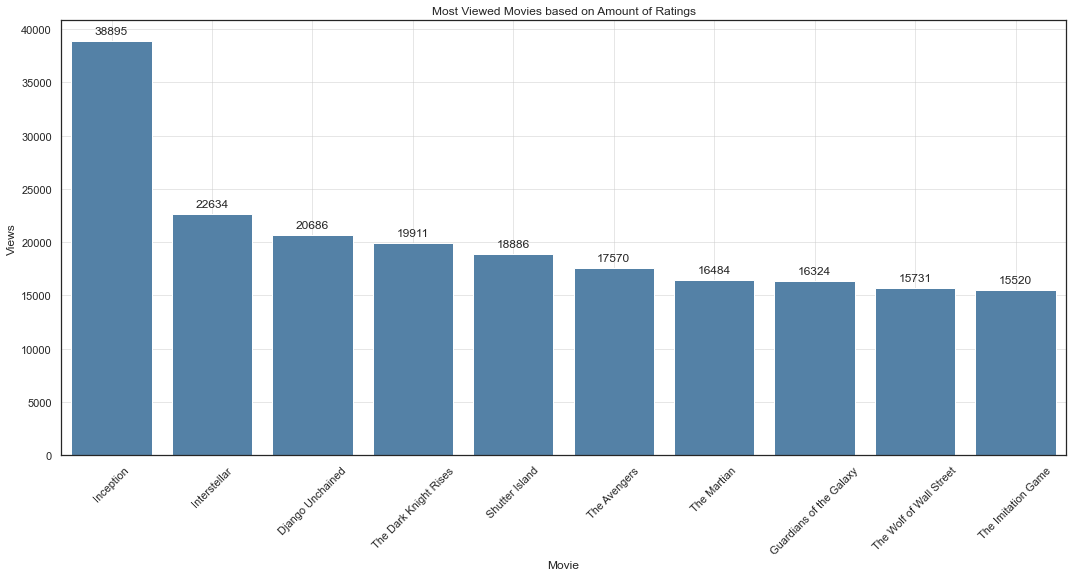

In [8]:
# change theme to white
sns.set_theme(style = "white")

# create barplot with the most viewed movies and add text to bars
ax = sns.barplot(data = df_movies_sum_ratings.iloc[:10,:], x = "title", y = "rating", color = "steelblue")

# add text to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set(xlabel = 'Movie', ylabel = 'Views', title = "Most Viewed Movies based on Amount of Ratings")
plt.xticks(rotation = 45)
plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

Inception ist der Film, welcher mit Abstand am meisten Ratings hat. Danach folgen Interstellar, Django Unchained und The Dark Knight Rises. Es ist überraschend auffällig, dass unter diesen Filmen 3x die Regie von Chrisopher Nolan geführt wurde. Alle diese Filme, welche am meisten bewertet wurden, gehören dem Genre Drama und Action an. Somit schliessen wir daraus, dass dies sehr beliebte Genres sind. Anhand von unserem Plot oben ("genre views based on amount of ratings"), können wir das sogar bestätigen. 

### 2. Wie verteilt sich die Anzahl ratings pro User?  

Als nächstes wollen wir herausfinden, wieviele Filme ein User ungefähr bewertet. Somit können wir sehen, ob ein bestimmter User im Durchschnitt eher viele oder eher weniger Filme bewertet hat. 

/Users/luuzemp14/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


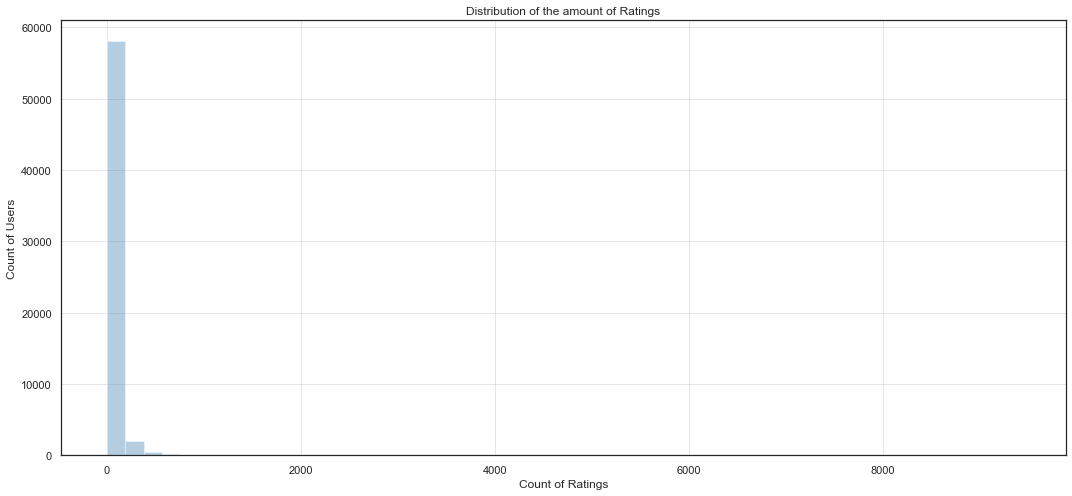

In [9]:
# plot the distribution of ratings per user x amount max 1000

# change theme to white
sns.set_theme(style = "white")

ax = sns.distplot(df_movies_ratings.groupby("userId")["rating"].count(), bins = 50, kde = False, color = "steelblue")
ax.set(xlabel = 'Count of Ratings', ylabel = "Count of Users", title = "Distribution of the amount of Ratings")
plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()


Auf dem Plot kann man kaum etwas erkennen, da es einen User gibt, der fast 9'500 Filme bewertet hat. Allerdings sieht man, dass die meisten User zwischen 0 und 200 Filme bewerteten. aus diesem Grund, machen wir den gleichen Plot nochmals, ändern aber die X-Achse so, dass wir nur bis zu 200 Ratings pro User ansehen. 

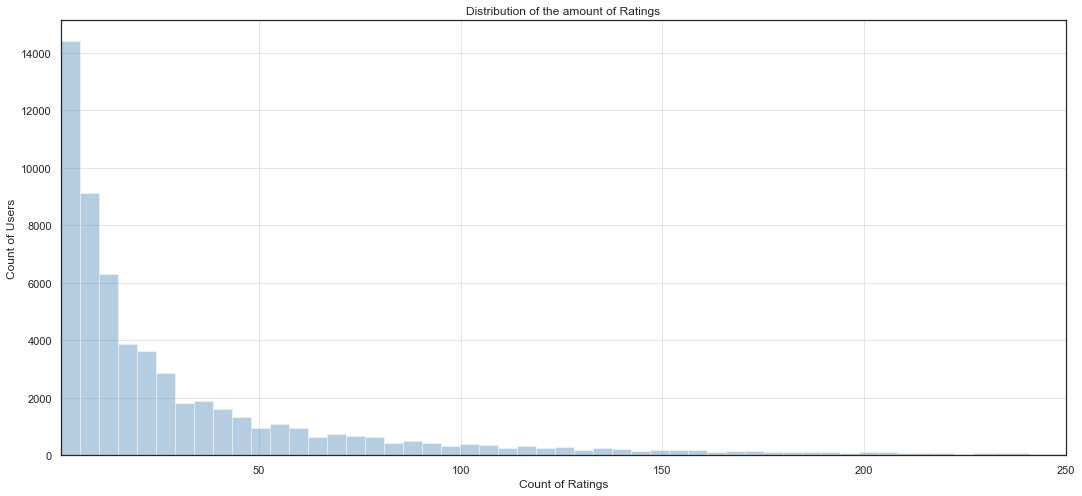

In [10]:
# plot the distribution of ratings per user x amount max 1000

# change theme to white
sns.set_theme(style = "white")

ax = sns.distplot(df_movies_ratings.groupby("userId")["rating"].count(), bins = 2000, kde = False, color = "steelblue")
ax.set_xlim(1, 250)
ax.set(xlabel = 'Count of Ratings', ylabel = "Count of Users", title = "Distribution of the amount of Ratings")
plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

Nun sieht man schon viel besser, wie sich die Anzahl Ratings verteilt. Die aller meisten User haben "nur" zwischen 1 und 20 Filmen bewertet. Bei über 200 Bewertungen, sind es nur noch sehr weniger User. 

Uns nimmt wunder, wieviele Ratings der User mit den meisten Bewertungen abgegeben hat. 

In [11]:
# max rating count per user
most_ratings = df_movies_ratings.groupby("userId")["rating"].count().max()
print(f" Der User mit den meisten Bewertungen hat {most_ratings} Bewertungen abgegeben.")

 Der User mit den meisten Bewertungen hat 9417 Bewertungen abgegeben.


Der User mit den aktuell meisten Ratings hat also 9417 Bewertungen abgegeben. Dies ist aber ein ganz klarer Ausreiser. Ob der User wirklich diese 9417 Filme gesehen hat ist stark zu bezweifeln.

#### 3. Wie verteilen sich die Kundenratings gesamthaft und nach Genres?

Mit dieser Frage wollen wir herausfinden, welches die beliebtesten Genres sind und welche Genres am schwächsten bewertet wurden.

Dazu haben wir ein neues Dataframe "df_genres_ratings" erstellt, in dem wir nach Genres sortiert haben und alle abgegebenen Ratings hinzugefügt haben.

In [12]:
lst2 = []

# loop through all genres (last 19 columns)
for i in df_genres.iloc[:,-19:].columns:
    # if rating is 1, add genre to list
    lst2.append([i, df_genres[df_genres[i] == 1]["rating"].tolist()])

# create dataframe from lst2 and unpack the list of ratings
df_genres_ratings = pd.DataFrame(lst2, columns = ["Genre", "Rating"])

# explode the list of ratings --> each rating will turn into a row with its corresponding genre
df_genres_ratings = df_genres_ratings.explode("Rating")
df_genres_ratings

,Genre,Rating
0,Action,4.0
0,Action,3.5
0,Action,3.0
0,Action,5.0
0,Action,5.0
...,...,...
18,Western,2.5
18,Western,0.5
18,Western,0.5
18,Western,1.0


Wir haben nun anhand dieses neuen Dataframes einen Boxplot erstellt. Somit können wir die Verteilung der Ratings pro Genre gut mit einander vergleichen

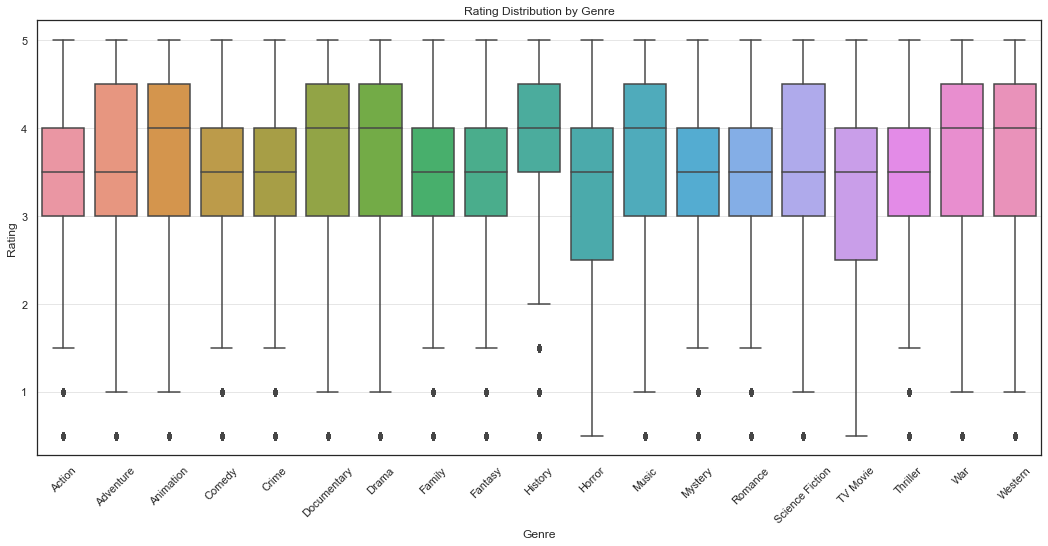

In [13]:
# plot rating by genre

# change theme to white
sns.set_theme(style = "white")

ax = sns.boxplot(data = df_genres_ratings, x = "Genre", y = "Rating")
ax.set(xlabel = "Genre", ylabel = "Rating", title = "Rating Distribution by Genre")
plt.xticks(rotation = 45)
plt.grid(axis = "y", linewidth = 0.6, alpha = 0.8)
plt.show()

Wir erkennen, dass das Genre History die besten Bewertungen erhalten hat. Die Genres Horror und TV Movie haben mit die schlechtesten Bewertungen erhalten.

#### 4. Wie verteilen sich die mittleren Kundenratings pro Film?

Wir haben als aller erstes die Durchschnittsbewertung für jeden Film berechnet um danach ein Histogramm mit den durchschnittlichen Ratings pro Film zu erstellen. Mit einer roten Linie haben wir den Durchschnitt aller durchschnittlichen Bewertungen gekennzeichnet. Dieser liegt bei einem Rating von ca. 3.1. 

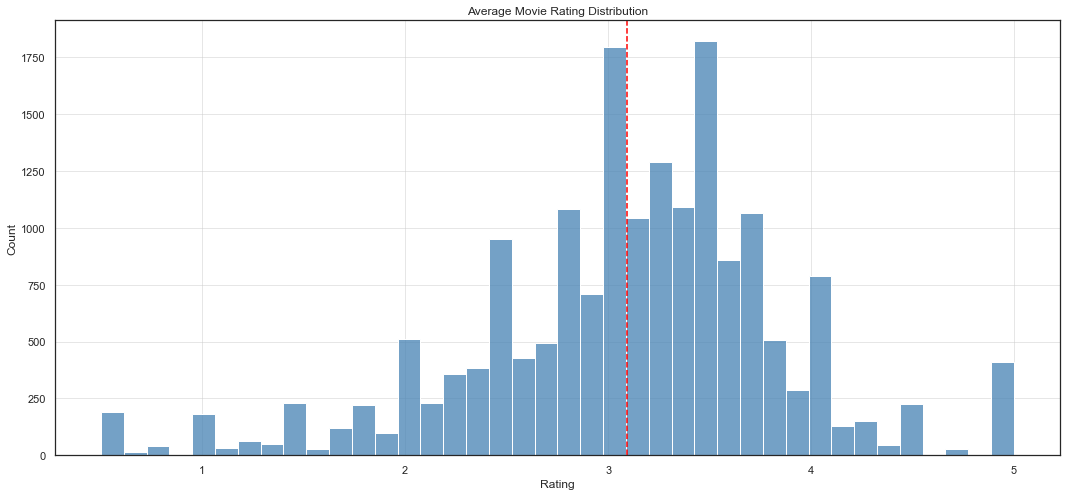

In [14]:
# group title and calculate average rating
df_movies_avg_ratings = df_movies_ratings.groupby("title")["rating"].mean().reset_index()

# change theme to white
sns.set_theme(style = "white")

# create histogram with average ratings
ax = sns.histplot(data = df_movies_avg_ratings, x = "rating", bins = 40, color="steelblue")

# add line that represents the mean of the dataset
ax.axvline(df_movies_avg_ratings["rating"].mean(), color = "red", linestyle = "--")

# set labels
ax.set(xlabel = "Rating", ylabel = "Count", title = "Average Movie Rating Distribution")
plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

Hier sehen wir, dass die meisten Filme durchschnittlich zwischen 3 & 3.5 bewertet wurden und dass die Verteilung aller Bewertungen ungefähr normalverteilt ist. Auffällig sind auch die Balken ganz links und ganz rechts. Dies erklären wir uns dadurch, dass es viele User gibt, die einen Film entweder extrem gerne haben und eine 5 geben oder die einen Film garnicht mochten und die tiefste Bewertung gaben.

#### 5. Wie stark streuen die Ratings von individuellen Kunden?

Als Stichprobe nehmen wir 3 User (user13, user44, user101) und schauen, wie sich deren Ratings verteilen.

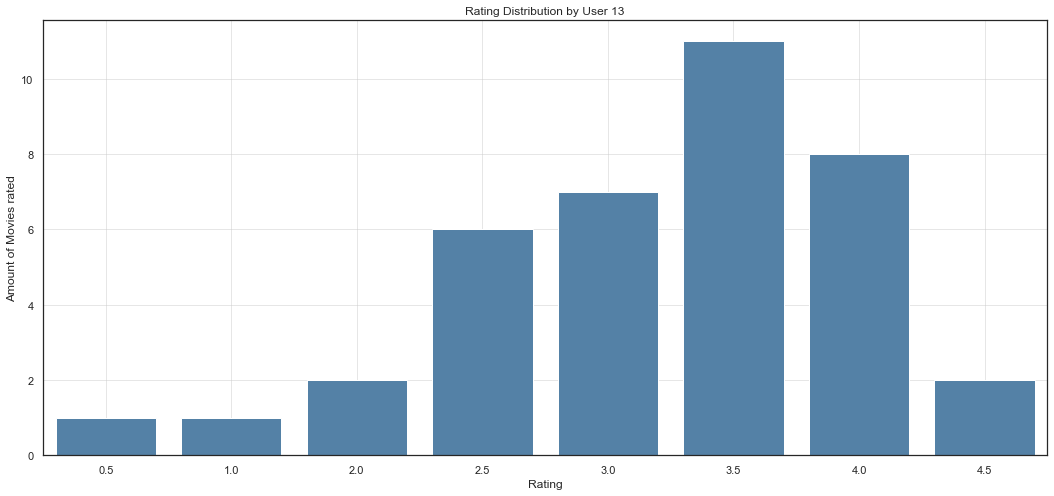

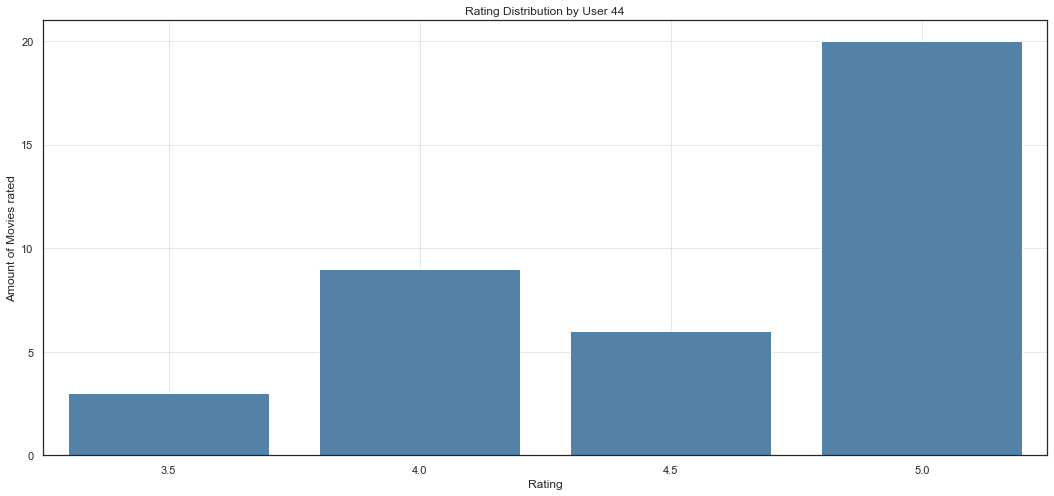

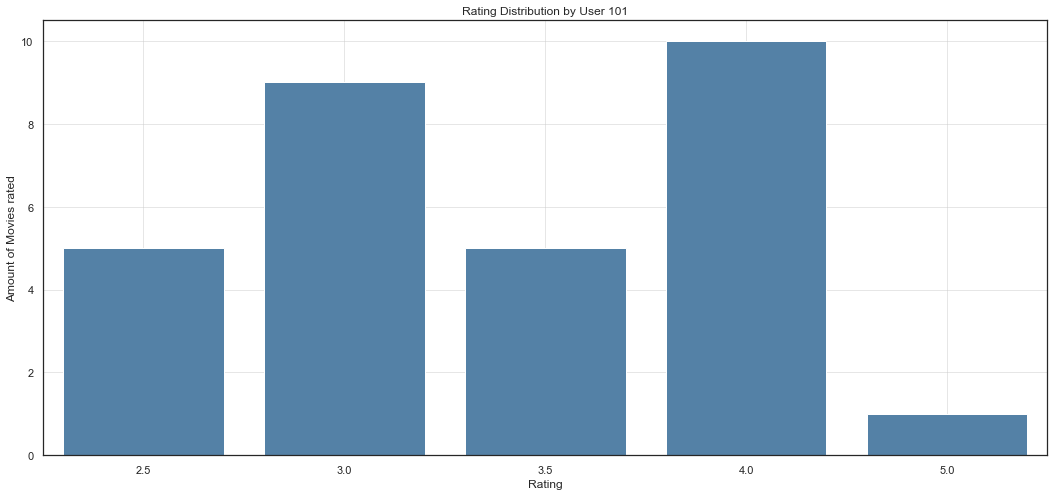

In [15]:
def user_rating(id):
    # create barplot with ratings from user
    ax = sns.barplot(data = df_genres[df_genres["userId"] == id].groupby("rating")["title"].count().reset_index(), x = "rating", y = "title", color = "steelblue")

    # change y axis to integer (example: because its not possible to rate 12.5 movies)
    plt.locator_params(axis='y', integer = True)

    # set labels
    ax.set(xlabel='Rating', ylabel='Amount of Movies rated', title="Rating Distribution by User {}".format(id))
    
    plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
    plt.show()

user_rating(13)
user_rating(44)
user_rating(101)

Beim User13 ist die Verteilung ähnlich wie beim Plot mit den Ratings für alle User. Beim User44 fällt auf, dass er wahrscheinlich nur die Filme geratet hat, die er mochte, da alle seine ratings 3.5 und höher sind. Wir gehen davon aus, dass er Filme, die er nicht mochte, garnicht erst bewertet hat. Beim User 101 ist die Bewertung wieder ungefähr normalverteilt mit Peak bei 3.0 und 4.0. 

### 6. Welchen Einfluss hat die Normierung der Ratings pro Kunde auf deren Verteilung?
Normierung (auch Normalisierung): die Skalierung eines Wertes auf einen bestimmten Wertebereich, üblicherweise zwischen 0 und 1 (bzw. 0 und 100 %)

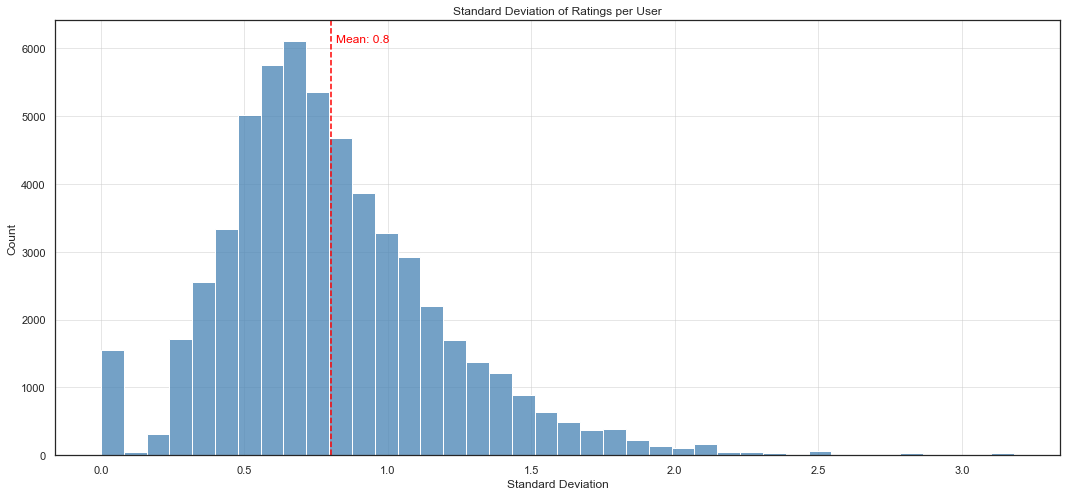

In [16]:
# group by user and calculate standard deviation of their ratings
ax = sns.histplot(data = df_movies_ratings.groupby("userId")["rating"].std().reset_index(), x = "rating", color = "steelblue", bins = 40)

# add line that represents the mean of the dataset
ax.axvline(df_movies_ratings.groupby("userId")["rating"].std().mean(), color = "red", linestyle = "--")

# show the value of the line that represents the mean of the dataset
ax.text(0.821, 6090, "Mean: {}".format(round(df_movies_ratings.groupby("userId")["rating"].std().mean(), 2)), color = "red")

ax.set(xlabel = "Standard Deviation", ylabel = "Count", title = "Standard Deviation of Ratings per User")

plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

### 7. Wie sieht die Verteilung der Filmlängen aus?

Im Python Notebook "datawrangling" haben wir die Kurzfilme, welche weniger als 30 Minuten gehen und Filme mit einer Länge von über 5 Stunden entfernt, da sie unserer Meinung nach nicht wirklich relevant sind.

Die rote Linie entspricht dem Durchschnitt der Filmlängen, also 117 Minuten. (knapp 2h)

/Users/luuzemp14/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


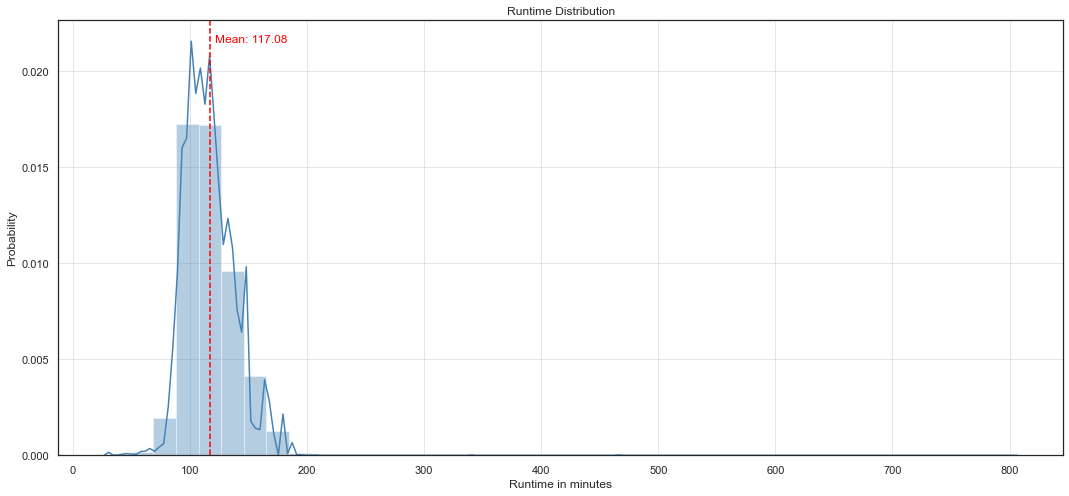

In [17]:
# distplot of runtime
ax = sns.distplot(df_movies_ratings["runtime"], bins = 40, color = "steelblue")

# add line that represents the mean of the dataset
ax.axvline(df_movies_ratings["runtime"].mean(), color = "red", linestyle = "--")

# show the value of the mean line
ax.text(121, 0.0215, "Mean: {}".format(round(df_movies_ratings["runtime"].mean(), 2)), color = "red")

# set labels
ax.set(xlabel = "Runtime in minutes", ylabel = "Probability", title = "Runtime Distribution")

plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

Wir sehen, dass die Filme oft mals zwischen ca. 70 und 180 Minuten lang dauern. Der Mittelwert liegt bei 117 Minuten. 

In [44]:
lst3 = []

# loop through all genres (last 19 columns)
for i in df_genres.iloc[:,-19:].columns:
    # if rating is 1, add genre to list
    lst3.append([i, df_genres[df_genres[i] == 1]["runtime"].tolist()])

# create dataframe from lst2 and unpack the list of ratings
df_genres_runtime = pd.DataFrame(lst3, columns = ["Genre", "Runtime"])

# explode the list of ratings --> each rating will turn into a row with its corresponding genre
df_genres_runtime = df_genres_runtime.explode("Runtime")
df_genres_runtime["Runtime"] = df_genres_runtime["Runtime"].astype(int)
df_genres_runtime["Runtime"]

0      92
0      76
0     122
0      93
0     100
     ... 
18    177
18     90
18     77
18    104
18    100
Name: Runtime, Length: 5085, dtype: int64

Da wir nun die Verteilung der durschnittlichen Filmdauer kennengelernt haben, nimmt uns wunder, welches Genre im Durchschnitt die längsten Filme beinhaltet. Dazu erstellen wir einen Barplot, der alle Genres 

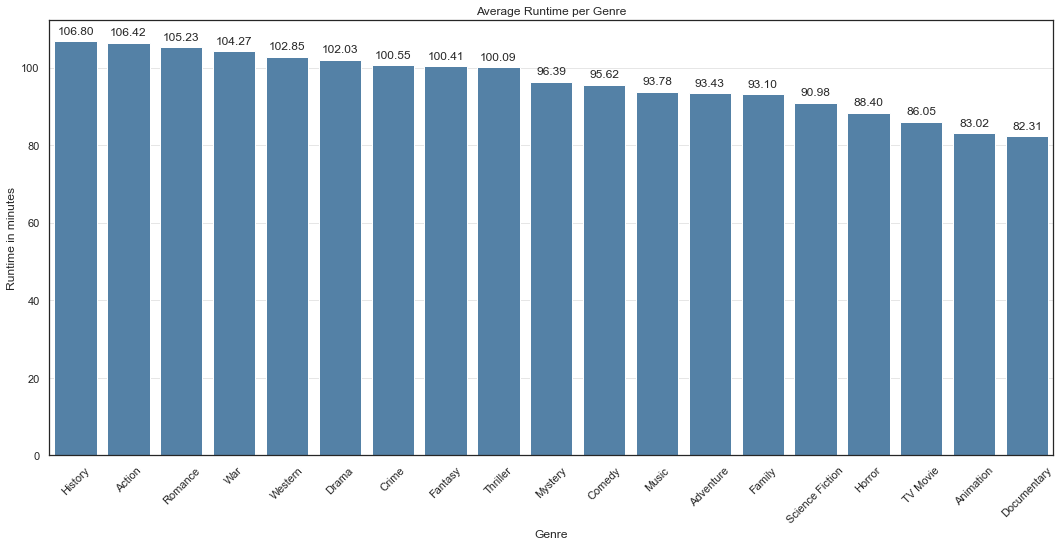

In [79]:
# plot the average runtime per genre sortet by runtime
ax = sns.barplot(data = df_genres_runtime.groupby("Genre")["Runtime"].mean().reset_index().sort_values("Runtime", ascending = False), x = "Genre", y = "Runtime", color = "steelblue")

# set labels
ax.set(xlabel = "Genre", ylabel = "Runtime in minutes", title = "Average Runtime per Genre")

# show y value for each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# rotate x axis labels
plt.xticks(rotation = 45)

# add grid
plt.grid(axis = "y", linewidth = 0.6, alpha = 0.8)
plt.show()

Wir sehen, dass das Genre History im Durchschnitt die längsten Filme hat und das Genre Dokumentationen die kürzesten. 

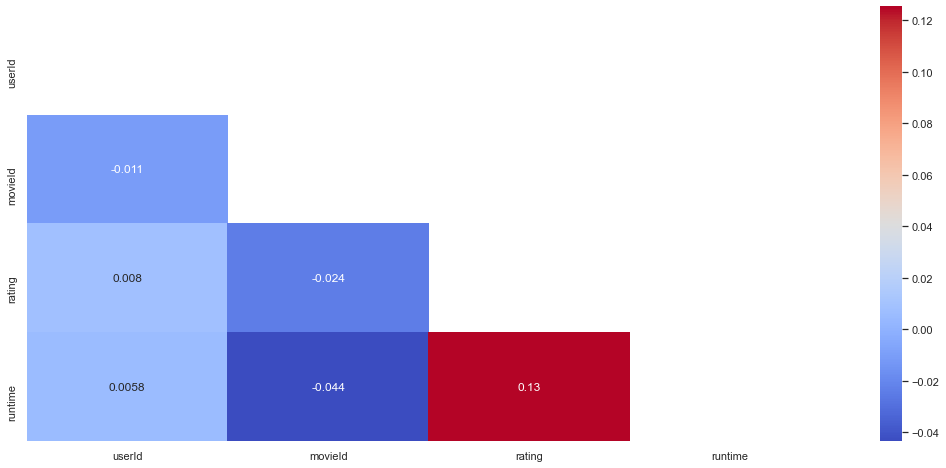

In [78]:
# create a correlation matrix between runtime and average rating of movies as heatmap without diagonal
import numpy as np

ax = sns.heatmap(df_movies_ratings.corr(), annot = True, cmap = "coolwarm", mask = np.triu(np.ones_like(df_movies_ratings.corr(), dtype = bool)))

Dank dieser Heatmap können wir eine leichte Korrelation zwischen der Lauflänge eines Filmes und dessen durchschnittlicher Bewertung erkennen. 

In [ ]:
# plot runtime by genre

# change theme to white

In [18]:
# group by movie_id 
df_genres = df_genres.groupby("movieId").sum().reset_index()
df_genres


,movieId,userId,rating,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,895,95394,6.0,220,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1,2679,158072,4.0,168,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,4249,528708,13.5,616,0,0,0,7,0,7,...,0,0,0,0,0,0,0,0,0,0
3,4484,2503108,114.0,3040,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5904,167377,6.5,285,3,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18488,209133,273505,5.0,220,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
18489,209143,145795,1.0,107,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
18490,209145,145795,1.0,132,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
18491,209157,119571,1.5,100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# create a plot with the average runtime per genres
ax = sns.histplot(data = df_genres.groupby("genres")["runtime"].mean().reset_index(), x = "genres", y = "runtime", color = "steelblue")

# set labels
ax.set(xlabel = "Genre", ylabel = "Runtime in minutes", title = "Average Runtime per Genre")
plt.xticks(rotation = 45)
plt.grid(axis = "y", linewidth = 0.6, alpha = 0.8)
plt.show()

KeyError: 'genres'

### 8. Anzahl Filme pro Jahr
Hierzu wird das Jahr aus der Spalte "release_date" entnommen und in einer neuen Spalte "year" hinzugefügt. Somit können wir nach dem Erscheinungsjahr gruppieren und die Anzahl Filme zählen.

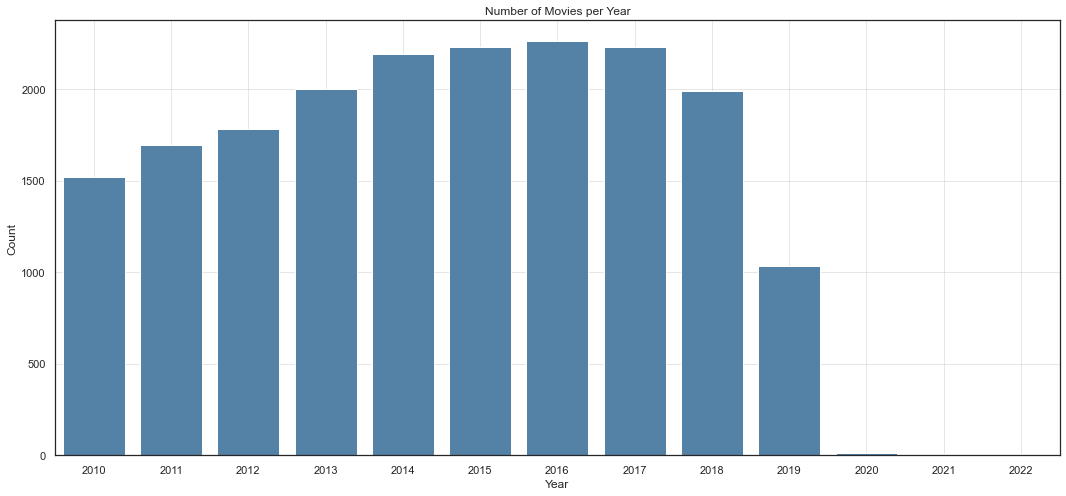

In [ ]:
# extract year from release_date and add to new col
df_movies_clean["year"] = df_movies_clean["release_date"].apply(lambda x: x.split("-")[0])

# group by year and count movies
df_movies_year = df_movies_clean.groupby("year")["title"].count().reset_index()

# plot lineplot
ax = sns.barplot(data = df_movies_year, x = "year", y = "title", color = "steelblue")

# set labels
ax.set(xlabel = "Year", ylabel = "Count", title = "Number of Movies per Year")

plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

### 9. In welcher originalen Sprache wurden die meisten Filme gedreht?

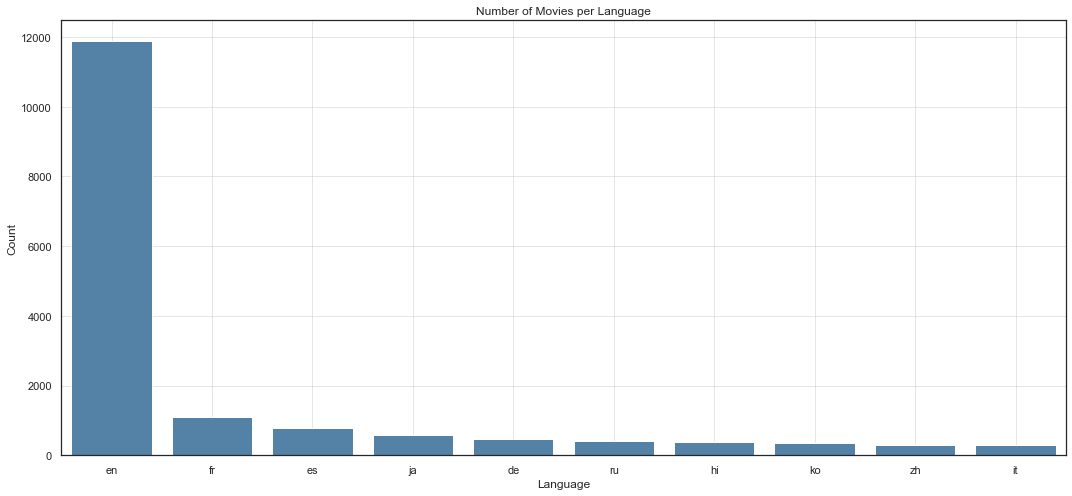

In [ ]:
# barplot with original language and show amount of movies per language
ax = sns.barplot(data = df_movies_clean.groupby("original_language")["title"].count().reset_index().sort_values("title", ascending = False).head(10), x = "original_language", y = "title", color = "steelblue")

# set labels
ax.set(xlabel = "Language", ylabel = "Count", title = "Number of Movies per Language")

plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
plt.show()

In [ ]:
# group by original language and show amount
df_movies_clean.groupby("original_language")["title"].count().reset_index().sort_values("title", ascending = False).head(10)

,original_language,title
15,en,11883
22,fr,1088
16,es,773
34,ja,570
13,de,459
65,ru,416
26,hi,384
39,ko,359
86,zh,306
32,it,298


## Filmtext Daten

In dem nächsten Abschnitt werden die Filmtext Daten analysiert (Filmbeschreibungen & Titel).



1. Gestemmte Wörter
2. Wörter Verteilt
3. Wie viel Wörter und texte
4. Wie sich die Texte verändert haben

Eine Kopie erstellen für die "stemmed" Daten.

In [ ]:
df_movies_stemmed = df_movies_clean.copy().reset_index(drop = True)

Wir müssen noch die NaN Felder mit einem leeren String austauschen, damit die Stemming Funktion 2funktioniert.

In [ ]:
# replace nan with empty string
df_movies_stemmed = df_movies_stemmed.fillna("")

Hier werden die Wörter auf dem Wortstamm reduziert --> somit werden die gleiche Wörter zusammengefasst. Z.B "Swimming" wird zu "Swim"

In [ ]:
cols = ["title", "overview", "spoken_languages", "original_language", "production_companies", "production_countries"]

df_movies_stemmed = df_movies_stemmed[cols]

# loop through the chosen columns and stem the words
for col in cols:
    df_movies_stemmed[col] = stemming_tokenizer(df_movies_stemmed[col])

df_movies_stemmed.head()

,title,overview,spoken_languages,original_language,production_companies,production_countries
0,venic,atmospher come age stori featur imagin young b...,esk deutsch polski,pl,akson studio iti cinema,poland
1,place tabl,use person stori power documentari illumin pli...,english,en,,unit state america
2,kingdom come,documentari kingdom come follow first time dir...,,en,,
3,camil claudel,winter confin famili asylum south franc never ...,fran ai,fr,art franc cin canal product pictanovo region paca,franc
4,kingdom,th centuri princ regent qing dynasti order mas...,,zh,,china


### 1. Welche Wörter kommen am häufigsten in den Filmbeschreibungen vor?
Um die Texte in Vektoren umzuwandeln verwenden wir CountVectorizer. CountVectorizer wandelt eine Sammlung von Textdokumenten (hier data) in eine Term-Dokument-Matrix (hier word_count_matrix) um, in der jedes Dokument als Vektor von Wortzählungen dargestellt wird. Dies bedeutet, dass jedes Wort in den Dokumenten als Feature betrachtet wird und der Wert des Features der Häufigkeit des Wortes in dem Dokument entspricht.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_words(data, data_type):
    
    # create count vectorizer
    count_vectorizer = CountVectorizer(stop_words="english", analyzer = "word", ngram_range=(1, 2))

    # fit and transform data (convert the documents into vectors)
    word_count_matrix = count_vectorizer.fit_transform(data)

    # get words
    word_array = count_vectorizer.get_feature_names()

    # get top 15 words
    top_15_words = [word_array[i] for i in np.argsort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:15]]

    # get top 15 word counts (sorted)
    top_15_words_count = np.sort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:15]

    # create barplot
    ax = sns.barplot(x = top_15_words, y = top_15_words_count, color = "steelblue")

    # set labels
    ax.set(xlabel = "\nWord", ylabel = "Count\n", title = "Most Common Words in {}".format(data_type))

    plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
    plt.show()

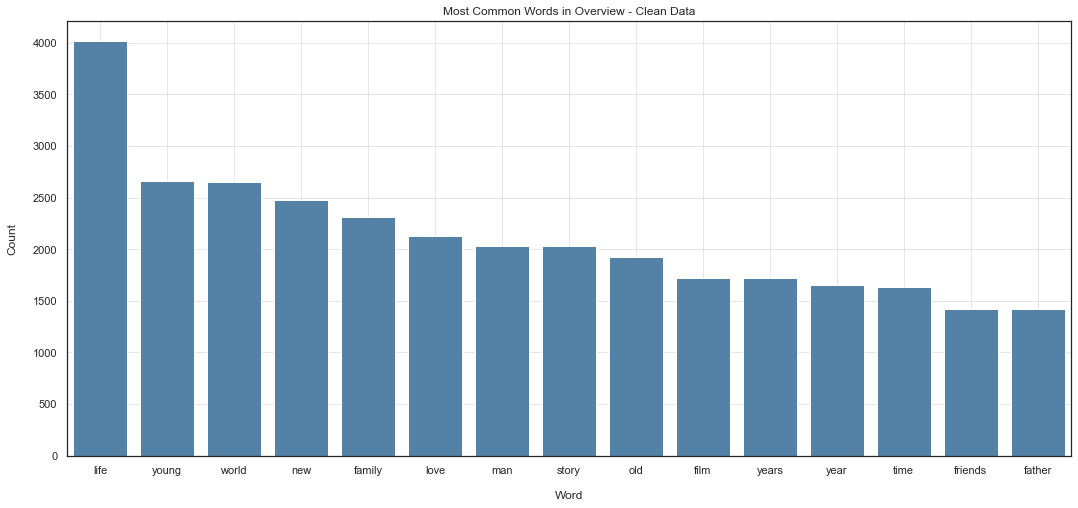

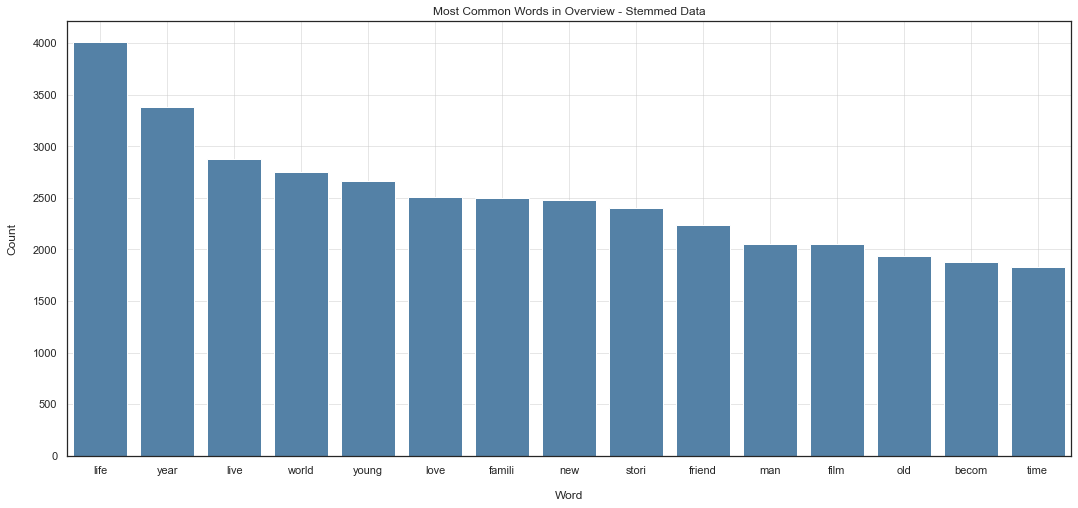

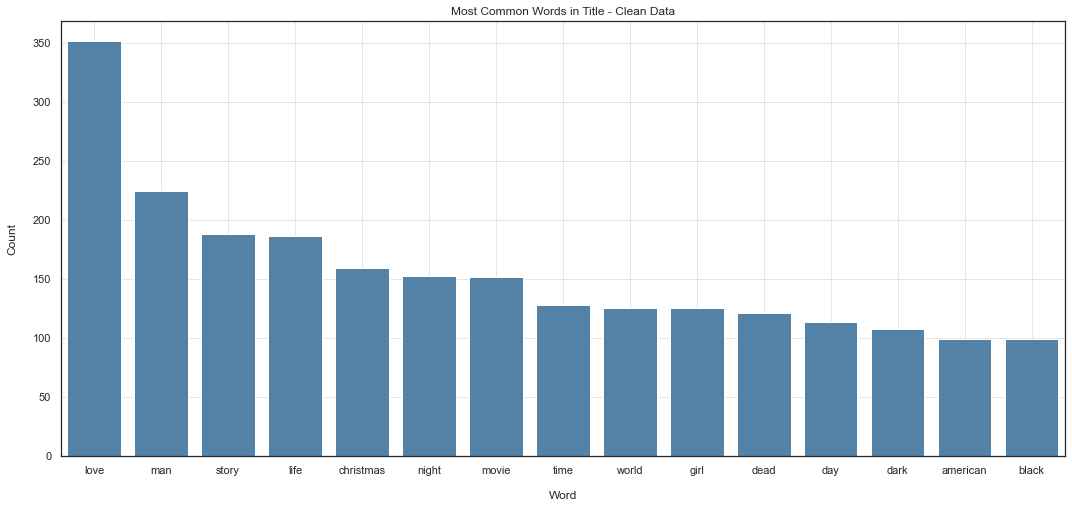

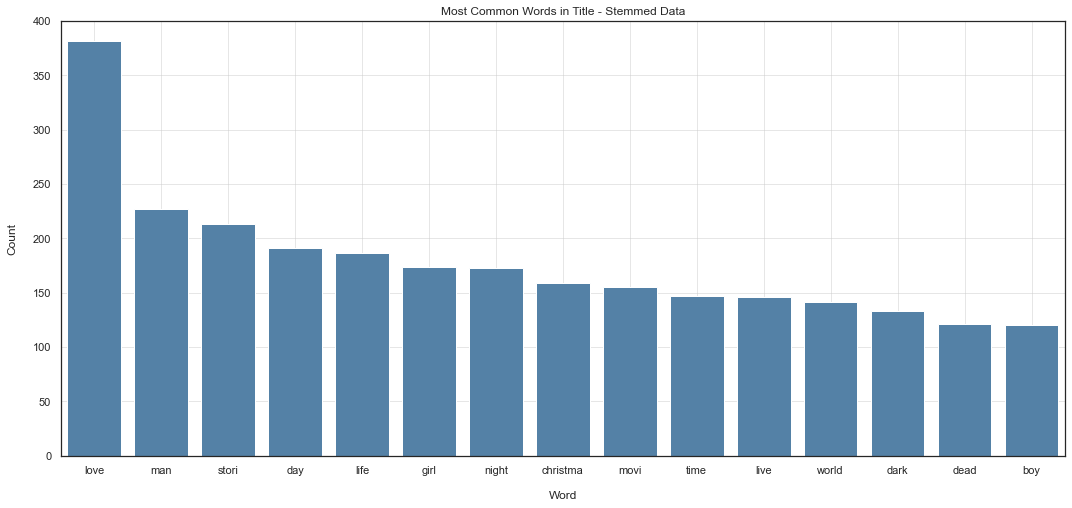

In [ ]:
count_words(df_movies_clean["overview"], "Overview - Clean Data")
count_words(df_movies_stemmed["overview"], "Overview - Stemmed Data")

count_words(df_movies_clean["title"], "Title - Clean Data")
count_words(df_movies_stemmed["title"], "Title - Stemmed Data")

Bemerkungen (Vor und Nacher):


### 2. Wie lange sind die Wörter?
Wir erstellen eine Funktion, welche die Anzahl Buchstaben aller Wörter zählt und in einem Dataframe zurückgibt.

In [ ]:
def word_length(data):
    # get each word from data and add to list
    lst = []
    for i in data:
        for j in i.split():
            lst.append(j)

    # create dataframe with word and length of word
    df = pd.DataFrame(lst, columns = ["Word"])
    
    # add length of word to dataframe
    df["Length"] = df["Word"].apply(lambda x: len(x))

    return df

df_word_length = word_length(df_movies_clean["overview"])
df_word_length_stemmed = word_length(df_movies_stemmed["overview"])

In [ ]:
# show 10 longest words from df_movies_clean
df_word_length_stemmed.sort_values("Length", ascending = False).head(10)

,Word,Length
205611,youdontneediceforchardonnay,27
25472,kolkyttoistavuotiaat,20
512889,cambridgefilmfestiv,19
86061,azuloscurocasinegro,19
531839,uppgivenhetssyndrom,19
426856,nahasapeemapetilon,18
194947,schillergymnasium,17
513945,antiauthoritarian,17
235600,francisgleydisson,17
524369,uncompromisingli,16


In [ ]:
# group by length and count words
df_word_length.groupby("Length")["Word"].count().reset_index().tail(10)

,Length,Word
27,28,1
28,29,1
29,30,3
30,31,2
31,33,2
32,36,1
33,38,1
34,42,1
35,45,1
36,67,1


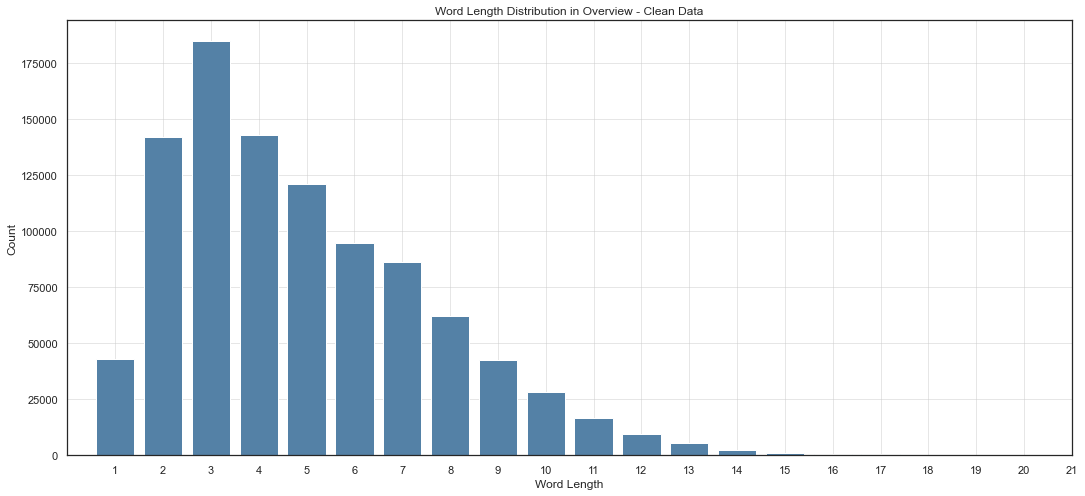

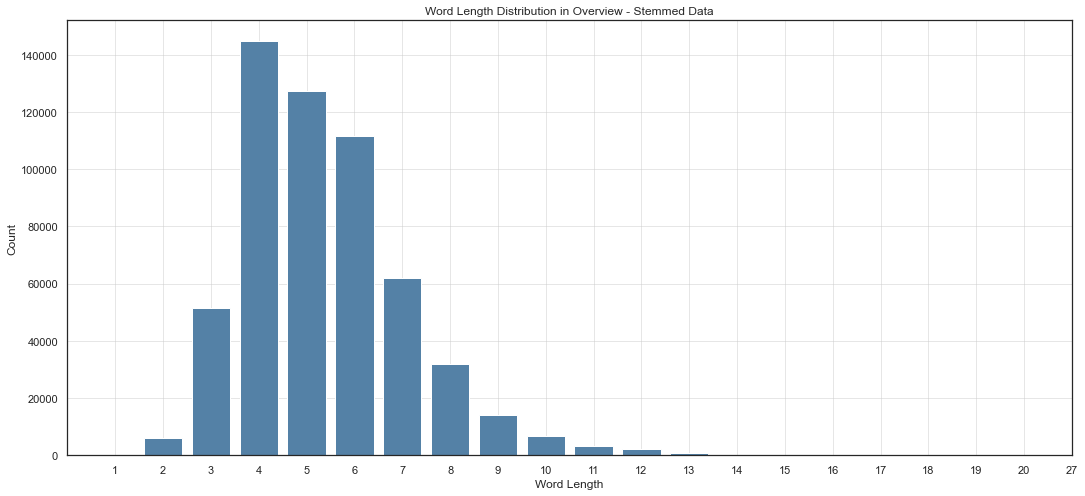

In [ ]:
def plot_word_length(data, data_type):

    # plot word length distribution without seaborn
    ax = sns.barplot(data = data.groupby("Length")["Word"].count().reset_index(), x = "Length", y = "Word", color = "steelblue")

    # set labels
    ax.set(xlabel = "Word Length", ylabel = "Count", title = "Word Length Distribution in {}".format(data_type))

    # limit x axis to 20
    plt.xlim(-1, 20)
    plt.grid(axis = "both", linewidth = 0.6, alpha = 0.8)
    plt.show()


plot_word_length(df_word_length, "Overview - Clean Data")
plot_word_length(df_word_length_stemmed, "Overview - Stemmed Data")

### 3. Wie viele Wörter gibt es überhaupt?

In [ ]:
def total_words(method, df):
    sum_words = df["overview"].apply(lambda x: len(x.split())).sum()
    print("The {} has {} words.".format(method, sum_words))

In [ ]:
total_words("Clean Dataframe", df_movies_clean)
total_words("Stemmed Dataframe", df_movies_stemmed)

The Clean Dataframe has 984763 words.
The Stemmed Dataframe has 562155 words.
